# Prerequisites

In [1]:
import numpy as np
import pandas as pd
import time
import csv
import random
import matplotlib.pyplot as plt
from PIL import Image
from barbar import Bar

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

use_gpu = torch.cuda.is_available()
print(use_gpu)

True


# Pre-define Value

In [2]:
# Paths to the files with training, and validation sets.
# Each file contains pairs (path to image, output vector)
Traindata = pd.read_csv('./CheXpert-v1.0-small/train.csv')
Traindata = Traindata[Traindata['Path'].str.contains("frontal")] # use only frontal images
Traindata = Traindata[500:]
Traindata.to_csv('./CheXpert-v1.0-small/train_mod.csv', index = False)
print("Train data length:", len(Traindata))

Validdata = pd.read_csv('./CheXpert-v1.0-small/valid.csv')
Validdata = Validdata[Validdata['Path'].str.contains("frontal")] # use only frontal images
Validdata.to_csv('./CheXpert-v1.0-small/valid_mod.csv', index = False)
print("Valid data length:", len(Validdata))

Testdata = Traindata.head(500) # use first 500 training data as test data (obs ratio is almost same!)
Testdata.to_csv('./CheXpert-v1.0-small/test_mod.csv', index = False)
print("Test data length:", len(Testdata))

pathFileTrain = './CheXpert-v1.0-small/train_mod.csv'
pathFileValid = './CheXpert-v1.0-small/valid_mod.csv'
pathFileTest = './CheXpert-v1.0-small/test_mod.csv'

# Neural network parameters:
nnIsTrained = False     # pre-trained using ImageNet
nnClassCount = 14       # dimension of the output

# Training settings: batch size, maximum number of epochs
trBatchSize = 16
trMaxEpoch = 3

# Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = (320, 320)
imgtransCrop = 224

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

Train data length: 190527
Valid data length: 202
Test data length: 500


# Create a Dataset

In [3]:
class CheXpertDataSet(Dataset):
    def __init__(self, data_PATH, transform = None, policy = "ones"):
        """
        data_PATH: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        Upolicy: name the policy with regard to the uncertain labels.
        """
        image_names = []
        labels = []

        with open(data_PATH, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None) # skip the header
            for line in csvReader:
                image_name = line[0]
                label = line[5:]
                
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0
                        
                image_names.append('./' + image_name)
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)

# Load Datasets

In [4]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # mean of ImageNet dataset(for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]   # std of ImageNet dataset(for normalization)

# Tranform data
normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
transformList = []

transformList.append(transforms.Resize((imgtransCrop, imgtransCrop))) # 224
# transformList.append(transforms.RandomResizedCrop(imgtransCrop))
# transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
# transformList.append(normalize)
transformSequence = transforms.Compose(transformList)

# Load dataset
datasetTrain = CheXpertDataSet(pathFileTrain, transformSequence, policy = "ones")
print("Train data length:", len(datasetTrain))

datasetValid = CheXpertDataSet(pathFileValid, transformSequence)
print("Valid data length:", len(datasetValid))

datasetTest = CheXpertDataSet(pathFileTest, transformSequence, policy = "ones")
print("Test data length:", len(datasetTest))

Train data length: 190527
Valid data length: 202
Test data length: 500


# Create train and test Models

In [6]:
class CheXpertTrainer():

    def train(model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, checkpoint):
        optimizer = optim.Adam(model.parameters(), lr = 0.0001, # setting optimizer & scheduler
                               betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0) 
        loss = torch.nn.BCELoss() # setting loss function
        
        if checkpoint != None and use_gpu: # loading checkpoint
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])
            
        # Train the network
        lossMIN = 100000
        train_start = []
        train_end = []
        for epochID in range(0, trMaxEpoch):
            train_start.append(time.time()) # training starts
            losst = CheXpertTrainer.epochTrain(model, dataLoaderTrain, optimizer, trMaxEpoch, nnClassCount, loss)
            train_end.append(time.time()) # training ends
            lossv = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss)
            print("Training loss: {:.3f},".format(losst), "Valid loss: {:.3f}".format(lossv))
            
            if lossv < lossMIN:
                lossMIN = lossv
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 
                            'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 
                           'm-epoch_FL' + str(epochID + 1) + '.pth.tar')
                print('Epoch ' + str(epochID + 1) + ' [save] loss = ' + str(lossv))
            else:
                print('Epoch ' + str(epochID + 1) + ' [----] loss = ' + str(lossv))

        train_time = np.array(train_end) - np.array(train_start)
        print("Training time for each epoch: {} seconds".format(train_time.round(0)))
        params = model.state_dict()
        return params
       
        
    def epochTrain(model, dataLoaderTrain, optimizer, epochMax, classCount, loss):
        losstrain = 0
        model.train()

        for batchID, (varInput, target) in enumerate(Bar(dataLoaderTrain)):
            
            varTarget = target.cuda(non_blocking = True)
            varOutput = model(varInput)
            lossvalue = loss(varOutput, varTarget)
                       
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
            losstrain += lossvalue.item()
            
        return losstrain / len(dataLoaderTrain)
    
    
    def epochVal(model, dataLoaderVal, optimizer, epochMax, classCount, loss):
        model.eval()
        lossVal = 0

        with torch.no_grad():
            for i, (varInput, target) in enumerate(dataLoaderVal):
                
                target = target.cuda(non_blocking = True)
                varOutput = model(varInput)
                
                lossVal += loss(varOutput, target)
                
        return lossVal / len(dataLoaderVal)

    
    def computeAUROC(dataGT, dataPRED, classCount):
        # Computes area under ROC curve 
        # dataGT: ground truth data
        # dataPRED: predicted data
        outAUROC = []
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        
        for i in range(classCount):
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            except ValueError:
                pass
        return outAUROC
    
    
    def test(model, dataLoaderTest, nnClassCount, checkpoint, class_names):
        cudnn.benchmark = True
        
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])

        if use_gpu:
            outGT = torch.FloatTensor().cuda()
            outPRED = torch.FloatTensor().cuda()
        else:
            outGT = torch.FloatTensor()
            outPRED = torch.FloatTensor()
       
        model.eval()
        
        with torch.no_grad():
            for i, (input, target) in enumerate(dataLoaderTest):

                target = target.cuda()
                outGT = torch.cat((outGT, target), 0).cuda()

                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)
            
                out = model(varInput)
                outPRED = torch.cat((outPRED, out), 0)
        aurocIndividual = CheXpertTrainer.computeAUROC(outGT, outPRED, nnClassCount)
        aurocMean = np.array(aurocIndividual).mean()
        print('AUROC mean ', aurocMean)
        
        for i in range (0, len(aurocIndividual)):
            print(class_names[i], ' ', aurocIndividual[i])
        
        return outGT, outPRED

# Define the Model

In [7]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained = False)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

# Train the model with Federated Learning

In [ ]:
# FOR MULTIPLE COMMUNICATION ROUNDS
com_round = 3
fraction = 1.0
epoch = 3
batch = 48
num_clients = 5

'''
# Divide datasetTrain_ex
datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5, dataleft = random_split(datasetTrain, 
                                                                                                        [100, 100, 100, 100, 100,
                                                                                                         len(datasetTrain) - 500])
'''
# Divide datasetTrain_real
datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5 = random_split(datasetTrain, 
                                                                                              [38106, 38106, 38105, 38105, 38105])


# Define 5 DataLoaders
dataLoaderTrain_1 = DataLoader(dataset = datasetTrain_1, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_2 = DataLoader(dataset = datasetTrain_2, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_3 = DataLoader(dataset = datasetTrain_3, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_4 = DataLoader(dataset = datasetTrain_4, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_5 = DataLoader(dataset = datasetTrain_5, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)

# Define Valid and Test DataLoaders
dataLoaderVal = DataLoader(dataset = datasetValid, batch_size = trBatchSize, 
                           shuffle = False, num_workers = 2, pin_memory = True)
dataLoaderTest = DataLoader(dataset = datasetTest, num_workers = 2, pin_memory = True)

In [8]:
dT = [datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5]
dLT = [dataLoaderTrain_1, dataLoaderTrain_2, dataLoaderTrain_3, dataLoaderTrain_4, dataLoaderTrain_5]

model = DenseNet121(nnClassCount).cuda() # Step 0: Initialize global model and load the model
model = torch.nn.DataParallel(model).cuda()

for i in range(com_round):
    print("[[[ Round {} Start ]]]".format(i + 1))
    params = [None] * num_clients
    sel_clients = sorted(random.sample(range(num_clients), 
                                       round(num_clients*fraction))) # Step 1: select random fraction of clients
    print("The number of clients:", len(sel_clients))
    for j in sel_clients: # Step 2: send weights to clients
        print("<< Client {} Training Start >>".format(j + 1))
        train_valid_start = time.time()
        params[j] = CheXpertTrainer.train(model, dLT[j], dataLoaderVal, # Step 3: Perform local computations
                                          nnClassCount, trMaxEpoch = epoch, checkpoint = None)
        train_valid_end = time.time()
        client_time = round(train_valid_end - train_valid_start)
        print("<< Client {} Training End: {} seconds elapsed >>".format(j + 1, client_time))
        
    fidx = [idx for idx in range(len(params)) if params[idx] != None][0]
    lidx = [idx for idx in range(len(params)) if params[idx] != None][-1]
    for key in params[fidx]: # Step 4: return updates to server
        weights, weightn = [], []
        for k in sel_clients:
            weights.append(params[k][key]*len(dT[k]))
            weightn.append(len(dT[k]))
        params[lidx][key] = sum(weights) / sum(weightn) # weighted averaging model weights

    model = DenseNet121(nnClassCount).cuda()
    model = torch.nn.DataParallel(model).cuda()
    model.load_state_dict(params[lidx]) # Step 5: server updates global state
    print("[[[ Round {} End ]]]".format(i + 1))
    
print("Global model trained")

Number of clients:  5
38106/38106: [===============================>] - ETA 2.1ssss
Training loss: 0.403, Valid loss: 0.405
Epoch 1 [save] loss = tensor(0.4050, device='cuda:0')
38106/38106: [===============================>] - ETA 0.8sss
Training loss: 0.379, Valid loss: 0.418
Epoch 2 [----] loss = tensor(0.4181, device='cuda:0')
38106/38106: [===============================>] - ETA 0.6sss
Training loss: 0.371, Valid loss: 0.416
Epoch 3 [----] loss = tensor(0.4156, device='cuda:0')
Training time for each epoch: [622. 224. 189.] seconds
Client 1 training ends with 1039 seconds in round 1
38106/38106: [===============================>] - ETA 2.1ssss
Training loss: 0.374, Valid loss: 0.407
Epoch 1 [save] loss = tensor(0.4069, device='cuda:0')
38106/38106: [===============================>] - ETA 0.8sss
Training loss: 0.366, Valid loss: 0.415
Epoch 2 [----] loss = tensor(0.4151, device='cuda:0')
38106/38106: [===============================>] - ETA 0.6sss
Training loss: 0.358, Valid loss:

38105/38105: [===============================>] - ETA 0.9sss
Training loss: 0.285, Valid loss: 0.404
Epoch 2 [----] loss = tensor(0.4040, device='cuda:0')
38105/38105: [===============================>] - ETA 0.6sss
Training loss: 0.241, Valid loss: 0.514
Epoch 3 [----] loss = tensor(0.5143, device='cuda:0')
Training time for each epoch: [747. 270. 193.] seconds
Client 5 training ends with 1214 seconds in round 3
[[ Round 3 Ends]]
Model trained


# Test and ROC Curves

In [ ]:
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderTest, nnClassCount, None, class_names)

AUROC mean  0.8348945604671515
No Finding   0.8968205337690632
Enlarged Cardiomediastinum   0.8036729134376027
Cardiomegaly   0.8920946782178217
Lung Opacity   0.7752718815513626
Lung Lesion   0.8722817267121065
Edema   0.8744698897370653
Consolidation   0.7207095709570958
Pneumonia   0.7781929911974755
Atelectasis   0.7993981546065088
Pneumothorax   0.9068198040360782
Pleural Effusion   0.9133
Pleural Other   0.8096667193176433
Fracture   0.7679689830002981
Support Devices   0.877856


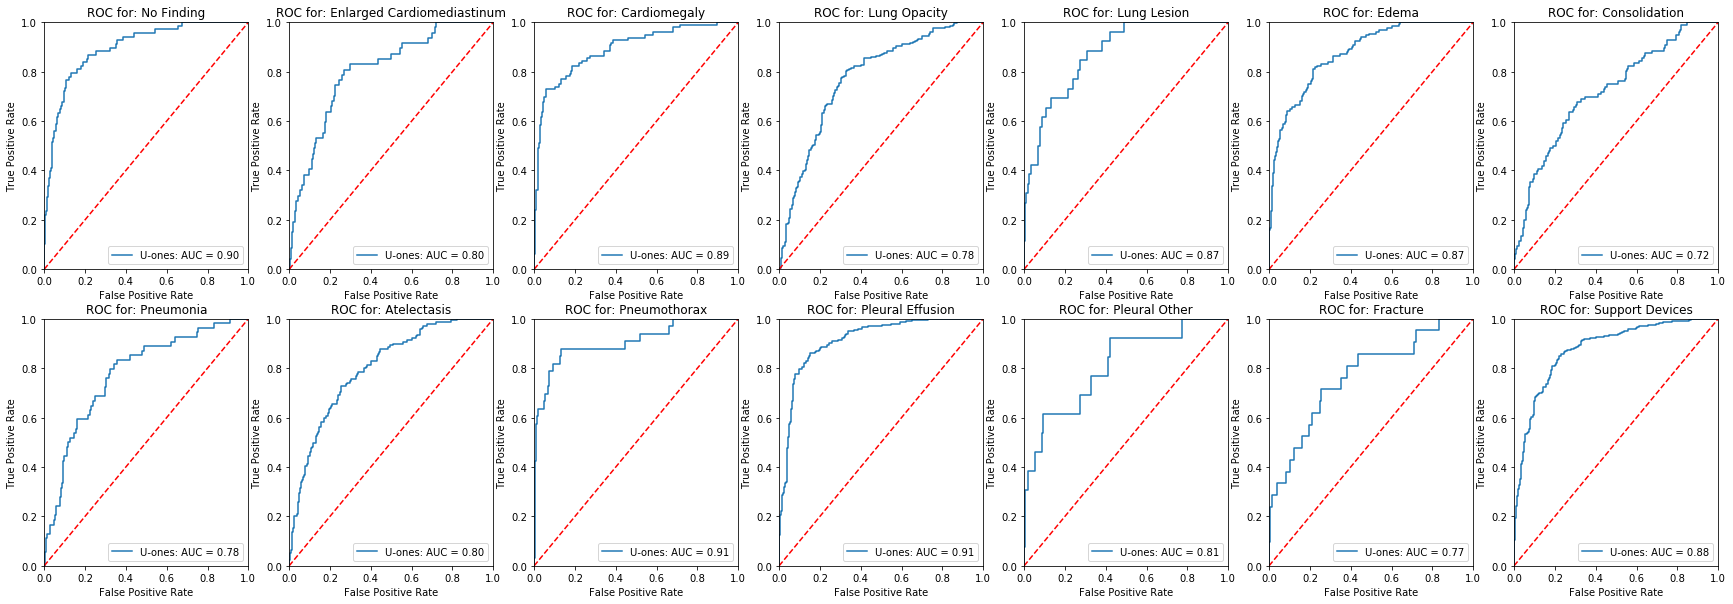

In [10]:
for i in range(nnClassCount):
    fpr, tpr, threshold = metrics.roc_curve(outGT.cpu()[:,i], outPRED.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)

    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (30, 10)

plt.savefig("ROC.png", dpi = 1000)
plt.show()

# Computational Stats

In [ ]:
# Took about 20 min per client(3 epoch) for a single round.
# Took about 60 min per clinet(3 epoch) for whole training.